In [ ]:
from datetime import datetime
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter


import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
%load_ext tensorboard

In [ ]:
from scipy.io import arff
import pandas as pd

file_path = "/content/adult.arff"
data, meta = arff.loadarff(file_path)

df = pd.DataFrame(data)

# print(df.head())
# print(df.info())


In [ ]:
analysis = {
    "Column": df.columns,
    "Missing Values": [df[col].isnull().sum() for col in df.columns],
    "Unique Values": [df[col].nunique() for col in df.columns],
    "Data Type": [df[col].dtype for col in df.columns],
}

analysis_df = pd.DataFrame(analysis)
analysis_df

,Column,Missing Values,Unique Values,Data Type
0,age,0,73,float64
1,workclass,0,9,object
2,fnlwgt,0,21648,float64
3,education,0,16,object
4,education-num,0,16,float64
5,marital-status,0,7,object
6,occupation,0,15,object
7,relationship,0,6,object
8,race,0,5,object
9,sex,0,2,object


#Download missing data such as 'b?'

In [ ]:
occupation_with_question = df[df['occupation'] == b'?']
workclass_with_question = df[df['workclass'] == b'?']
native_country_with_question = df[df['native-country'] == b'?']
race_with_othar = df[df['race'] == b'Other']

# merged_with_question = pd.concat([occupation_with_question, workclass_with_question, native_country_with_question])
# merged_with_question_unique = merged_with_question.drop_duplicates()
# merged_with_question_unique

df = df[~df['occupation'].isin(occupation_with_question['occupation']) &
                ~df['workclass'].isin(workclass_with_question['workclass']) &
                ~df['native-country'].isin(native_country_with_question['native-country'])&~df['race'].isin(race_with_othar['race'])]

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,b'State-gov',77516.0,b'Bachelors',13.0,b'Never-married',b'Adm-clerical',b'Not-in-family',b'White',b'Male',2174.0,0.0,40.0,b'United-States',b'<=50K'
1,50.0,b'Self-emp-not-inc',83311.0,b'Bachelors',13.0,b'Married-civ-spouse',b'Exec-managerial',b'Husband',b'White',b'Male',0.0,0.0,13.0,b'United-States',b'<=50K'
2,38.0,b'Private',215646.0,b'HS-grad',9.0,b'Divorced',b'Handlers-cleaners',b'Not-in-family',b'White',b'Male',0.0,0.0,40.0,b'United-States',b'<=50K'
3,53.0,b'Private',234721.0,b'11th',7.0,b'Married-civ-spouse',b'Handlers-cleaners',b'Husband',b'Black',b'Male',0.0,0.0,40.0,b'United-States',b'<=50K'
4,28.0,b'Private',338409.0,b'Bachelors',13.0,b'Married-civ-spouse',b'Prof-specialty',b'Wife',b'Black',b'Female',0.0,0.0,40.0,b'Cuba',b'<=50K'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,b'Private',257302.0,b'Assoc-acdm',12.0,b'Married-civ-spouse',b'Tech-support',b'Wife',b'White',b'Female',0.0,0.0,38.0,b'United-States',b'<=50K'
32557,40.0,b'Private',154374.0,b'HS-grad',9.0,b'Married-civ-spouse',b'Machine-op-inspct',b'Husband',b'White',b'Male',0.0,0.0,40.0,b'United-States',b'>50K'
32558,58.0,b'Private',151910.0,b'HS-grad',9.0,b'Widowed',b'Adm-clerical',b'Unmarried',b'White',b'Female',0.0,0.0,40.0,b'United-States',b'<=50K'
32559,22.0,b'Private',201490.0,b'HS-grad',9.0,b'Never-married',b'Adm-clerical',b'Own-child',b'White',b'Male',0.0,0.0,20.0,b'United-States',b'<=50K'


#encoded

In [ ]:
education_dict = df[['education', 'education-num']].set_index('education')['education-num'].to_dict()
columns_to_encode = ['relationship', 'race', 'sex', 'native-country', 'income', 'occupation', 'marital-status', 'workclass']
list_map_dict = {}
for column in columns_to_encode:
    df[f'{column}-encoded'], mapping = pd.factorize(df[column])
    mapping_dict = {index: category for index, category in enumerate(mapping)}
    list_map_dict[column] = mapping_dict
    print(f"Mapping for {column}:")
    print(mapping_dict)
    print("\n")

list_map_dict['education-encoded'] = education_dict

In [ ]:
columns_to_encode.append('education')
df_preprocessed = df.drop(columns=columns_to_encode)
df_preprocessed

In [ ]:
df_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29931 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     29931 non-null  float64
 1   fnlwgt                  29931 non-null  float64
 2   education-num           29931 non-null  float64
 3   capital-gain            29931 non-null  float64
 4   capital-loss            29931 non-null  float64
 5   hours-per-week          29931 non-null  float64
 6   relationship-encoded    29931 non-null  int64  
 7   race-encoded            29931 non-null  int64  
 8   sex-encoded             29931 non-null  int64  
 9   native-country-encoded  29931 non-null  int64  
 10  income-encoded          29931 non-null  int64  
 11  occupation-encoded      29931 non-null  int64  
 12  marital-status-encoded  29931 non-null  int64  
 13  workclass-encoded       29931 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 3.4 M

#narmlazish

#mini-max

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_normalize = df_preprocessed.select_dtypes(include=['float64', 'int64']).columns

df_preprocessed[columns_to_normalize] = scaler.fit_transform(df_preprocessed[columns_to_normalize])



        age    fnlwgt  education-num  capital-gain  capital-loss  \
0  0.301370  0.043338       0.800000       0.02174           0.0   
1  0.452055  0.047277       0.800000       0.00000           0.0   
2  0.287671  0.137244       0.533333       0.00000           0.0   
3  0.493151  0.150212       0.400000       0.00000           0.0   
4  0.150685  0.220703       0.800000       0.00000           0.0   

   hours-per-week  relationship-encoded  race-encoded  sex-encoded  \
0        0.397959                   0.0      0.000000          0.0   
1        0.122449                   0.2      0.000000          0.0   
2        0.397959                   0.0      0.000000          0.0   
3        0.397959                   0.2      0.333333          0.0   
4        0.397959                   0.4      0.333333          1.0   

   native-country-encoded  income-encoded  occupation-encoded  \
0                   0.000             0.0            0.000000   
1                   0.000             0.

In [ ]:
df_income = df_preprocessed.value_counts('income-encoded')
df_income

,count
income-encoded,
0.0,22444
1.0,7487


#split tha data to train and test
* 42
* 128
* 2048

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE

target_column = 'income-encoded'

X = df_preprocessed.drop(columns=[target_column])
y = df_preprocessed[target_column]

smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

seeds = [42, 128, 2048]
smote = SMOTE(random_state=42)

dict_tarin_test = {}
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    dict_tarin_test[seed] = (X_train_balanced, X_test, y_train_balanced, y_test)

    print(f"Seed: {seed}")
    print("Training target distribution after SMOTE:")
    print(y_train_balanced.value_counts(normalize=True))
    print("Testing target distribution:")
    print(y_test.value_counts(normalize=True))
    print("-" * 30)

Seed: 42
Training target distribution after SMOTE:
income-encoded
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64
Testing target distribution:
income-encoded
0.0    0.749791
1.0    0.250209
Name: proportion, dtype: float64
------------------------------
Seed: 128
Training target distribution after SMOTE:
income-encoded
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Testing target distribution:
income-encoded
0.0    0.749791
1.0    0.250209
Name: proportion, dtype: float64
------------------------------
Seed: 2048
Training target distribution after SMOTE:
income-encoded
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64
Testing target distribution:
income-encoded
0.0    0.749791
1.0    0.250209
Name: proportion, dtype: float64
------------------------------


# seed = 42

In [ ]:
 X_train, X_test, y_train, y_test=dict_tarin_test[42]
 print(X_train.shape)
 print(y_train.shape)
 print(X_test.shape)
 print(y_test.shape)


(35910, 13)
(35910,)
(5987, 13)
(5987,)


#GAN

##Generator

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_size, output_size, p_dropout=0.2):
        """
        Generator for tabular data with improvements:
        - Batch Normalization for stable training
        - LeakyReLU for better gradient flow
        - Dropout to prevent overfitting
        :param input_size: Size of the input noise vector.
        :param output_size: Number of features in the tabular data.
        :param p_dropout: Dropout probability (default: 0.2).
        """
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),         # Batch Normalization
            nn.LeakyReLU(0.2),          # LeakyReLU instead of ReLU
            nn.Dropout(p_dropout),      # Dropout for regularization

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p_dropout),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p_dropout),

            nn.Linear(512, output_size),
            nn.Sigmoid()  # Output normalized to [-1, 1]
        )

    def forward(self, noise):
        return self.model(noise)



##Discriminator

In [ ]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, input_size, p_dropout=0.3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(p_dropout),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(p_dropout),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # No Sigmoid here
        )

    def forward(self, x):
        return self.model(x)



In [ ]:
import torch.nn.functional as F

def compute_discriminator_loss(disc_real_output, disc_fake_output):
    """
    Compute the discriminator loss for real and fake data.
    :param disc_real_output: Output of the discriminator for real data.
    :param disc_fake_output: Output of the discriminator for fake data.
    :return: Total discriminator loss.
    """
    disc_loss_real = F.binary_cross_entropy_with_logits(
        disc_real_output, torch.ones_like(disc_real_output)
    )

    disc_loss_fake = F.binary_cross_entropy_with_logits(
        disc_fake_output, torch.zeros_like(disc_fake_output)
    )

    total_loss = disc_loss_real + disc_loss_fake
    return total_loss, disc_loss_real, disc_loss_fake


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

latent_dim = 100
input_dim = X_train.shape[1]
batch_size = 64
epochs = 20
# lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(input_size=latent_dim, output_size=input_dim).to(device)
discriminator = Discriminator(input_size=input_dim).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001)
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)


gen_losses = []
disc_losses = []
real_losses = []
fake_losses = []

for epoch in range(epochs):
    discriminator.train()
    generator.train()

    for step in range(len(X_train) // batch_size):
        # Prepare real and fake data
        real_data = torch.tensor(
            X_train.sample(batch_size).values, dtype=torch.float32
        ).to(device)
        real_labels = torch.ones((batch_size, 1)).to(device)

        noise = torch.randn((batch_size, latent_dim)).to(device)
        generated_data = generator(noise)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        # Discriminator loss
        disc_real_output = discriminator(real_data)
        disc_fake_output = discriminator(generated_data.detach())

        disc_loss, disc_loss_real, disc_loss_fake = compute_discriminator_loss(
            disc_real_output, disc_fake_output
        )
        optimizer_D.zero_grad()
        disc_loss.backward()
        optimizer_D.step()

        # Generator loss
        fake_labels_for_gen = torch.ones((batch_size, 1)).to(device)
        disc_generated_output = discriminator(generated_data)
        # print("disc_real_output shape:", disc_real_output.shape)
        # print("target shape (real):", torch.ones_like(disc_real_output).shape)
        # print("disc_fake_output shape:", disc_fake_output.shape)
        # print("target shape (fake):", torch.zeros_like(disc_fake_output).shape)
        gen_loss = criterion(disc_generated_output, fake_labels_for_gen)

        optimizer_G.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

        # Log losses
        gen_losses.append(gen_loss.item())
        disc_losses.append(disc_loss.item())
        real_losses.append(real_loss.item())
        fake_losses.append(fake_loss.item())

        # Print progress
        if step % 50 == 0:
            print(
                f"Epoch: {epoch}, Step: {step}, "
                f"Gen Loss: {gen_loss.item():.4f}, "
                f"Disc Real Loss: {disc_loss_real.item():.4f}, "
                f"Disc Fake Loss: {disc_loss_fake.item():.4f}"
            )

    # Visualize generated data
    with torch.no_grad():
        generator.eval()
        fixed_noise = torch.randn((16, latent_dim)).to(device)
        generated_fixed_data = generator(fixed_noise)
        # print(f"\nGenerated data samples (Epoch {epoch}):")
        # print(generated_fixed_data[:5].cpu().numpy())



Epoch: 0, Step: 0, Gen Loss: 0.6753, Disc Real Loss: 0.6845, Disc Fake Loss: 0.7163
Epoch: 0, Step: 50, Gen Loss: 0.7422, Disc Real Loss: 0.6635, Disc Fake Loss: 0.6593
Epoch: 0, Step: 100, Gen Loss: 0.7089, Disc Real Loss: 0.7156, Disc Fake Loss: 0.7267
Epoch: 0, Step: 150, Gen Loss: 0.8573, Disc Real Loss: 0.6330, Disc Fake Loss: 0.5601
Epoch: 0, Step: 200, Gen Loss: 1.1360, Disc Real Loss: 0.6520, Disc Fake Loss: 0.5228
Epoch: 0, Step: 250, Gen Loss: 0.9799, Disc Real Loss: 0.7106, Disc Fake Loss: 0.5308
Epoch: 0, Step: 300, Gen Loss: 1.5131, Disc Real Loss: 0.4413, Disc Fake Loss: 0.6809
Epoch: 0, Step: 350, Gen Loss: 0.6647, Disc Real Loss: 0.6798, Disc Fake Loss: 0.7655
Epoch: 0, Step: 400, Gen Loss: 0.8670, Disc Real Loss: 0.6690, Disc Fake Loss: 0.5596
Epoch: 0, Step: 450, Gen Loss: 0.9805, Disc Real Loss: 0.5492, Disc Fake Loss: 0.5679
Epoch: 0, Step: 500, Gen Loss: 0.6831, Disc Real Loss: 0.7800, Disc Fake Loss: 0.7641
Epoch: 0, Step: 550, Gen Loss: 0.9549, Disc Real Loss: 0.

#CGAN

In [ ]:
import torch
import torch.nn as nn

class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        """
        Conditional Generator for cGAN.
        :param noise_dim: Size of the input noise vector.
        :param label_dim: Number of possible labels (one-hot encoded).
        :param output_dim: Number of features in the generated sample.
        """
        super(ConditionalGenerator, self).__init__()
        self.input_dim = noise_dim + label_dim

        self.model = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Sigmoid()  # Normalized output for [0, 1]
        )

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)  # Concatenate noise and labels
        return self.model(x)

In [ ]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim, label_dim):
        """
        Conditional Discriminator for cGAN.
        :param input_dim: Number of features in the data.
        :param label_dim: Number of possible labels (one-hot encoded).
        """
        super(ConditionalDiscriminator, self).__init__()
        self.input_dim = input_dim + label_dim

        self.model = nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, data, labels):
        x = torch.cat([data, labels], dim=1)  # Concatenate data and labels
        return self.model(x)



In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Hyperparameters
latent_dim = 100
input_dim = X_train.shape[1]
num_labels = 2  # Binary classification (0 or 1)
batch_size = 64
epochs = 20
# lr = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator_c = ConditionalGenerator(noise_dim=latent_dim, label_dim=num_labels, output_dim=input_dim).to(device)
discriminator_c = ConditionalDiscriminator(input_dim=input_dim, label_dim=num_labels).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_D = optim.Adam(discriminator_c.parameters(), lr=0.0001)
optimizer_G = optim.Adam(generator_c.parameters(), lr=0.0002)

gen_c_losses = []
disc_c_losses = []
real_c_losses = []
fake_c_losses = []

X_train, X_test, y_train, y_test = dict_tarin_test[42]


X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


for epoch in range(epochs):
    discriminator_c.train()
    generator_c.train()

    for step, (real_data, real_labels) in enumerate(train_loader):
        # --- Step 1: Update Discriminator_c ---
        real_data = real_data.to(device)
        real_labels = real_labels.to(device)  # Binary labels (0 or 1)

        # Generate fake data
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, num_labels, (batch_size,)).to(device)  # Random binary labels
        fake_labels_onehot = F.one_hot(fake_labels, num_classes=num_labels).float()
        real_labels_onehot = F.one_hot(real_labels, num_classes=num_labels).float()
        fake_data = generator_c(noise, fake_labels_onehot)

        # Discriminator_c loss
        real_loss = F.binary_cross_entropy(
            discriminator_c(real_data, real_labels_onehot),
            torch.ones(batch_size, 1).to(device)
        )
        fake_loss = F.binary_cross_entropy(
            discriminator_c(fake_data.detach(), fake_labels_onehot),
            torch.zeros(batch_size, 1).to(device)
        )
        disc_loss = real_loss + fake_loss

        # Backpropagation for Discriminator_c
        optimizer_D.zero_grad()
        disc_loss.backward()
        optimizer_D.step()

        # --- Step 2: Update Generator_c ---
        # Generate fake data again
        fake_data = generator_c(noise, fake_labels_onehot)

        # Generator_c loss
        gen_loss = F.binary_cross_entropy(
            discriminator_c(fake_data, fake_labels_onehot),
            torch.ones(batch_size, 1).to(device)
        )

        # Backpropagation for Generator_c
        optimizer_G.zero_grad()
        gen_loss.backward()
        optimizer_G.step()

        # Log losses
        gen_c_losses.append(gen_loss.item())
        disc_c_losses.append(disc_loss.item())
        real_c_losses.append(real_loss.item())
        fake_c_losses.append(fake_loss.item())

        # Print progress
        if step % 50 == 0:
            print(
                f"Epoch: {epoch}, Step: {step}, "
                f"Gen Loss: {gen_loss.item():.4f}, "
                f"Disc Real Loss: {real_loss.item():.4f}, "
                f"Disc Fake Loss: {fake_loss.item():.4f}"
            )

    # Visualize generated data
    with torch.no_grad():
        generator_c.eval()
        fixed_noise = torch.randn((16, latent_dim)).to(device)
        fixed_labels = F.one_hot(torch.arange(0, 16) % num_labels, num_classes=num_labels).float().to(device)
        generated_fixed_data = generator_c(fixed_noise, fixed_labels)
        # Save or visualize generated data here

    print(f"Epoch {epoch + 1}/{epochs} | Disc Loss: {disc_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f}")



X_train_tensor shape: torch.Size([35910, 13])
y_train_tensor shape: torch.Size([35910])
X_test_tensor shape: torch.Size([5987, 13])
y_test_tensor shape: torch.Size([5987])
Epoch: 0, Step: 0, Gen Loss: 0.6660, Disc Real Loss: 0.6596, Disc Fake Loss: 0.7277
Epoch: 0, Step: 50, Gen Loss: 0.7183, Disc Real Loss: 0.7033, Disc Fake Loss: 0.6807
Epoch: 0, Step: 100, Gen Loss: 0.9053, Disc Real Loss: 0.6485, Disc Fake Loss: 0.5333
Epoch: 0, Step: 150, Gen Loss: 0.9588, Disc Real Loss: 1.0550, Disc Fake Loss: 0.5198
Epoch: 0, Step: 200, Gen Loss: 1.3103, Disc Real Loss: 0.6400, Disc Fake Loss: 0.3347
Epoch: 0, Step: 250, Gen Loss: 0.6608, Disc Real Loss: 1.0086, Disc Fake Loss: 0.7751
Epoch: 0, Step: 300, Gen Loss: 1.3823, Disc Real Loss: 0.3695, Disc Fake Loss: 0.3019
Epoch: 0, Step: 350, Gen Loss: 1.2307, Disc Real Loss: 0.3180, Disc Fake Loss: 0.3743
Epoch: 0, Step: 400, Gen Loss: 0.9139, Disc Real Loss: 1.0708, Disc Fake Loss: 0.6047
Epoch: 0, Step: 450, Gen Loss: 1.3246, Disc Real Loss: 0.

# for reput

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import seaborn as sns
import torch
import torch.nn.functional as F

# 6a: Provide information on the training process and plot losses
def plot_losses(generator_losses, discriminator_losses):
    """
    Plot the generator and discriminator losses over training steps.
    :param generator_losses: List of generator losses.
    :param discriminator_losses: List of discriminator losses.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('Generator and Discriminator Losses Over Training')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# 6b: Generate a synthetic dataset for GAN
def generate_synthetic_data_gan(generator, num_samples, latent_dim, device):
    """
    Generate a synthetic dataset using the trained GAN generator.
    :param generator: Trained generator model.
    :param num_samples: Number of samples to generate.
    :param latent_dim: Dimension of the noise vector.
    :param device: Device (CPU or GPU).
    :return: Synthetic data.
    """
    synthetic_data = []
    batch_size = 64

    for i in range(0, num_samples, batch_size):
        current_batch_size = min(batch_size, num_samples - i)
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        generated_data = generator(noise).detach().cpu().numpy()
        synthetic_data.append(generated_data)

    synthetic_data = np.vstack(synthetic_data)
    return synthetic_data

# 6b: Generate a synthetic dataset for cGAN
def generate_synthetic_data_cgan(generator, num_samples, latent_dim, num_labels, device):
    """
    Generate a synthetic dataset using the trained cGAN generator.
    :param generator: Trained generator model.
    :param num_samples: Number of samples to generate.
    :param latent_dim: Dimension of the noise vector.
    :param num_labels: Number of label categories.
    :param device: Device (CPU or GPU).
    :return: Synthetic data and labels.
    """
    synthetic_data = []
    synthetic_labels = []
    batch_size = 64

    for i in range(0, num_samples, batch_size):
        current_batch_size = min(batch_size, num_samples - i)
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        labels = torch.randint(0, num_labels, (current_batch_size,)).to(device)
        labels_onehot = F.one_hot(labels, num_classes=num_labels).float()
        generated_data = generator(noise, labels_onehot).detach().cpu().numpy()

        synthetic_data.append(generated_data)
        synthetic_labels.append(labels.cpu().numpy())

    synthetic_data = np.vstack(synthetic_data)
    synthetic_labels = np.hstack(synthetic_labels)
    return synthetic_data, synthetic_labels

# 6c: Visualize feature distributions and correlations
def compare_distributions(real_data, synthetic_data, feature_index):
    """
    Compare the distributions of a specific feature between real and synthetic data.
    :param real_data: Real dataset.
    :param synthetic_data: Synthetic dataset.
    :param feature_index: Index of the feature to compare.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(real_data[:, feature_index], bins=30, alpha=0.5, label='Real Data', density=True)
    plt.hist(synthetic_data[:, feature_index], bins=30, alpha=0.5, label='Synthetic Data', density=True)
    plt.title(f'Feature {feature_index} Distribution: Real vs. Synthetic')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def compare_correlations(real_data, synthetic_data):
    """
    Compare correlation matrices between real and synthetic data.
    :param real_data: Real dataset.
    :param synthetic_data: Synthetic dataset.
    """
    real_corr = np.corrcoef(real_data, rowvar=False)
    synthetic_corr = np.corrcoef(synthetic_data, rowvar=False)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(real_corr, cmap='coolwarm', center=0)
    plt.title('Real Data Correlation')

    plt.subplot(1, 2, 2)
    sns.heatmap(synthetic_corr, cmap='coolwarm', center=0)
    plt.title('Synthetic Data Correlation')

    plt.show()

# 6d-e: Detection metric
def calculate_detection_metric(real_data, synthetic_data):
    """
    Calculate the detection metric (average AUC) to evaluate how well the synthetic data matches the real data.
    :param real_data: Real dataset.
    :param synthetic_data: Synthetic dataset.
    :return: Average AUC.
    """
    combined_data = np.vstack([real_data, synthetic_data])
    combined_labels = np.hstack([np.ones(len(real_data)), np.zeros(len(synthetic_data))])

    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    aucs = []

    for train_idx, test_idx in kf.split(combined_data):
        X_train, X_test = combined_data[train_idx], combined_data[test_idx]
        y_train, y_test = combined_labels[train_idx], combined_labels[test_idx]

        clf = RandomForestClassifier(random_state=42, n_estimators=100)
        clf.fit(X_train, y_train)
        y_pred = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        aucs.append(auc)

    avg_auc = np.mean(aucs)
    print(f'Average AUC (Detection Metric): {avg_auc:.4f}')
    return avg_auc

# 6f: Efficacy metric
def calculate_efficacy_metric(real_train, real_test, real_labels_train, real_labels_test,
                              synthetic_data, synthetic_labels):
    """
    Calculate the efficacy metric to evaluate how useful the synthetic data is compared to real data.
    :param real_train: Real training dataset.
    :param real_test: Real testing dataset.
    :param real_labels_train: Labels for the real training dataset.
    :param real_labels_test: Labels for the real testing dataset.
    :param synthetic_data: Synthetic dataset.
    :param synthetic_labels: Labels for the synthetic dataset.
    :return: Real AUC, Synthetic AUC, Efficacy Ratio.
    """
    # Train on real data
    clf_real = RandomForestClassifier(random_state=42, n_estimators=100)
    clf_real.fit(real_train, real_labels_train)
    auc_real = roc_auc_score(real_labels_test, clf_real.predict_proba(real_test)[:, 1])

    # Train on synthetic data
    clf_synthetic = RandomForestClassifier(random_state=42, n_estimators=100)
    clf_synthetic.fit(synthetic_data, synthetic_labels)
    auc_synthetic = roc_auc_score(real_labels_test, clf_synthetic.predict_proba(real_test)[:, 1])

    # Calculate efficacy ratio
    efficacy_ratio = auc_synthetic / auc_real
    print(f'Real AUC: {auc_real:.4f}, Synthetic AUC: {auc_synthetic:.4f}, Efficacy Ratio: {efficacy_ratio:.4f}')
    return auc_real, auc_synthetic, efficacy_ratio





In [ ]:
print("=== Training Summary ===")
print(f"Number of epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {lr}")
print(f"Loss function: Binary Cross-Entropy Loss (BCE)")
print(f"Optimizer: Adam (beta1=0.9, beta2=0.999)")

=== Training Summary ===
Number of epochs: 20
Batch size: 64
Learning rate: 0.0002
Loss function: Binary Cross-Entropy Loss (BCE)
Optimizer: Adam (beta1=0.9, beta2=0.999)


#for gan

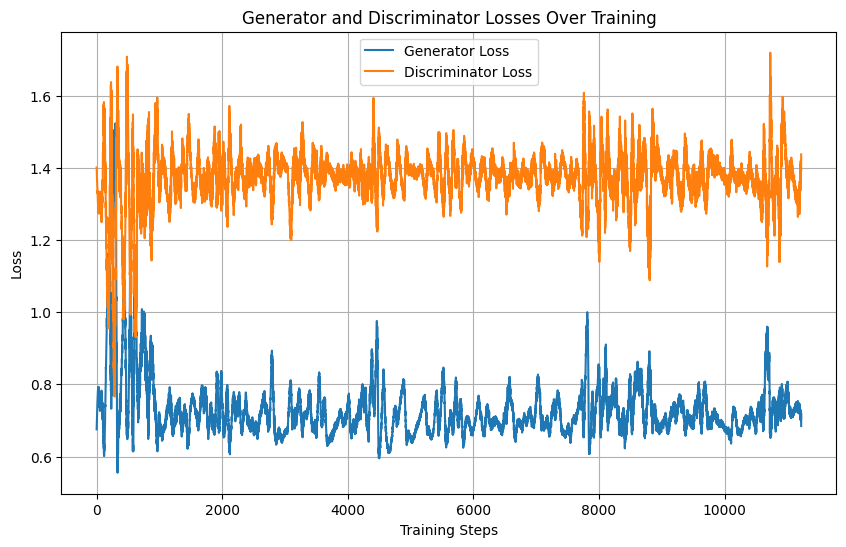

Synthetic Data (GAN) Shape: (35910, 13)


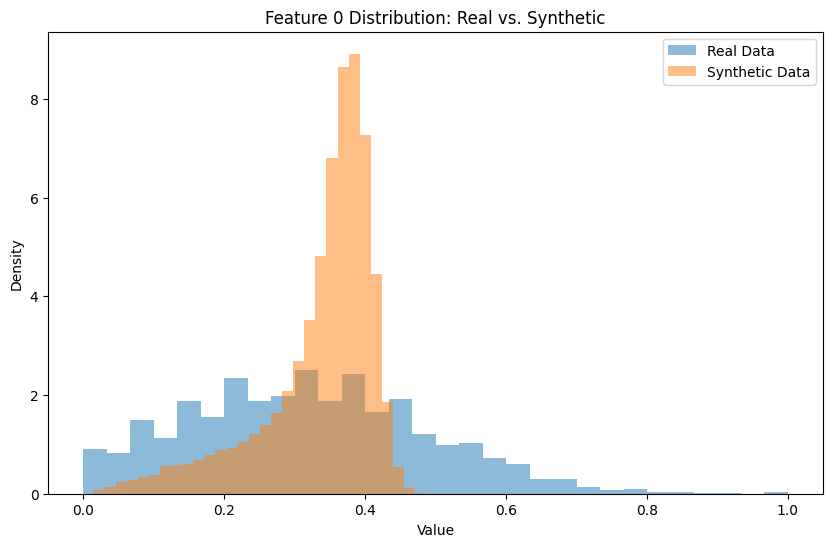

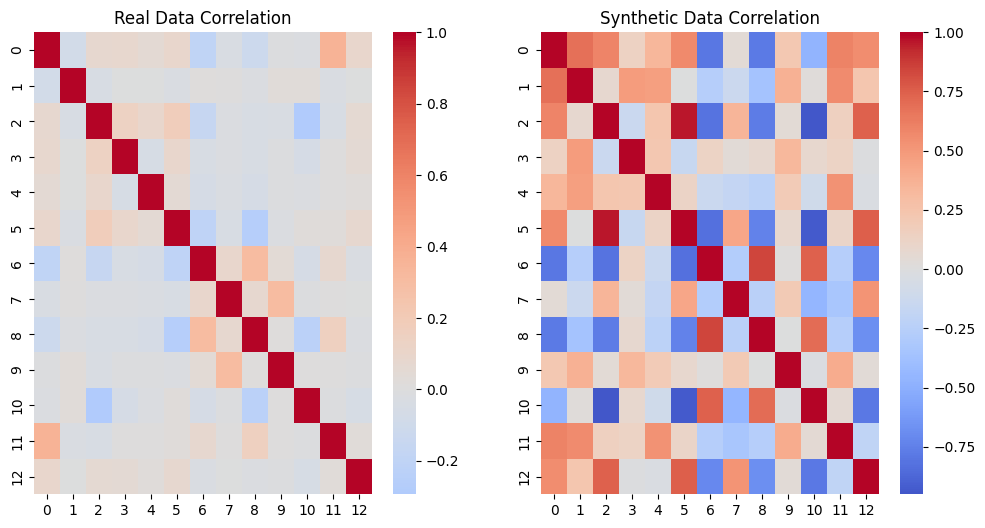

Average AUC (Detection Metric): 1.0000
Detection Metric (GAN) AUC: 1.0000
Real AUC: 0.9037, Synthetic AUC: 0.3413, Efficacy Ratio: 0.3777
Efficacy Metric (GAN):
Real AUC: 0.9037, Synthetic AUC: 0.3413, Ratio: 0.3777


In [ ]:
#6-a
plot_losses(gen_losses,disc_losses)

#6-b
num_samples = len(X_train)  # Match the size of the training data
synthetic_data_gan = generate_synthetic_data_gan(generator, num_samples, latent_dim, device)
print("Synthetic Data (GAN) Shape:", synthetic_data_gan.shape)

#6-c
compare_distributions(X_train.values, synthetic_data_gan, feature_index=0)

compare_correlations(X_train.values, synthetic_data_gan)

#6-d-e
auc_gan = calculate_detection_metric(X_train.values, synthetic_data_gan)
print(f'Detection Metric (GAN) AUC: {auc_gan:.4f}')

#6-f
# Train Random Forest using real data
auc_real_gan, auc_synthetic_gan, efficacy_ratio_gan = calculate_efficacy_metric(
    real_train=X_train.values,
    real_test=X_test.values,
    real_labels_train=y_train.values,
    real_labels_test=y_test.values,
    synthetic_data=synthetic_data_gan,
    synthetic_labels=y_train.values  # Assuming same label distribution
)

print(f'Efficacy Metric (GAN):\n'
      f'Real AUC: {auc_real_gan:.4f}, Synthetic AUC: {auc_synthetic_gan:.4f}, Ratio: {efficacy_ratio_gan:.4f}')

#for CGAN

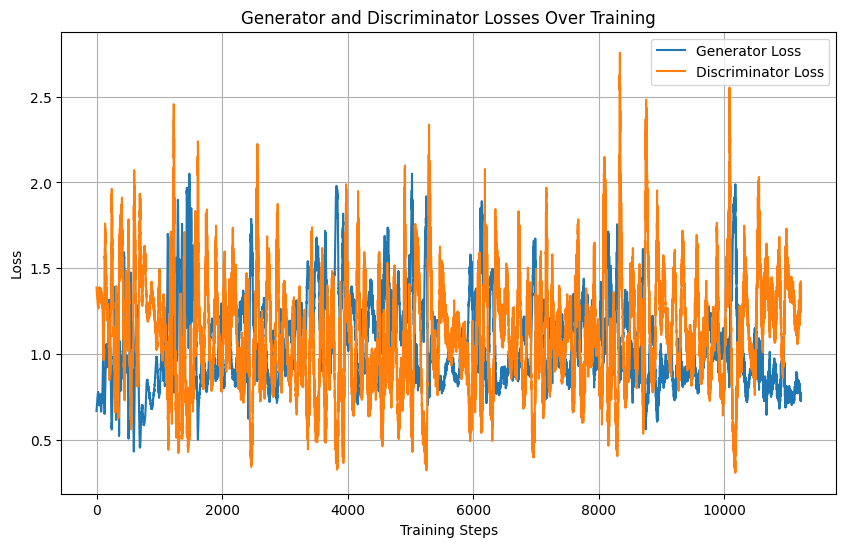

Synthetic Data (cGAN) Shape: (35910, 13)
Synthetic Labels (cGAN) Shape: (35910,)


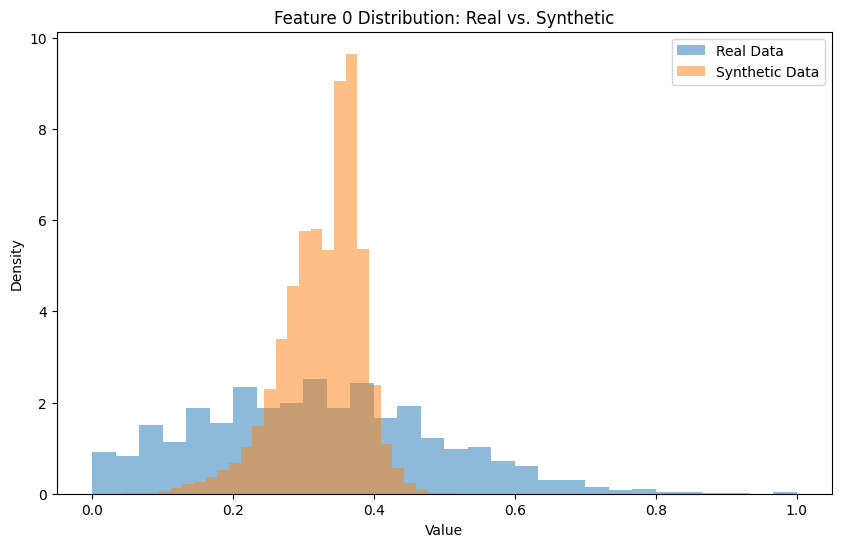

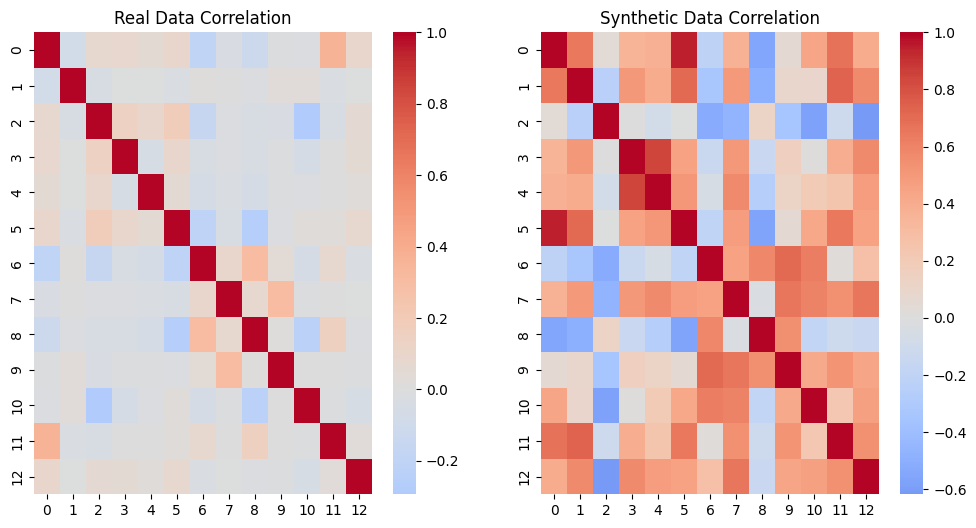

Average AUC (Detection Metric): 1.0000
Detection Metric (cGAN) AUC: 1.0000
Real AUC: 0.9037, Synthetic AUC: 0.7460, Efficacy Ratio: 0.8256
Efficacy Metric (cGAN):
Real AUC: 0.9037, Synthetic AUC: 0.7460, Ratio: 0.8256


In [ ]:
#6.a
plot_losses(gen_c_losses,disc_c_losses)

#6.b
synthetic_data_cgan, synthetic_labels_cgan = generate_synthetic_data_cgan(generator_c, num_samples, latent_dim, num_labels=2, device=device)
print("Synthetic Data (cGAN) Shape:", synthetic_data_cgan.shape)
print("Synthetic Labels (cGAN) Shape:", synthetic_labels_cgan.shape)

#6.c
compare_distributions(X_train.values, synthetic_data_cgan, feature_index=0)

compare_correlations(X_train.values, synthetic_data_cgan)

#6-d-e
# Calculate detection metric for cGAN
auc_cgan = calculate_detection_metric(X_train.values, synthetic_data_cgan)
print(f'Detection Metric (cGAN) AUC: {auc_cgan:.4f}')

#6-f
# Train Random Forest using synthetic data from cGAN
auc_real_cgan, auc_synthetic_cgan, efficacy_ratio_cgan = calculate_efficacy_metric(
    real_train=X_train.values,
    real_test=X_test.values,
    real_labels_train=y_train.values,
    real_labels_test=y_test.values,
    synthetic_data=synthetic_data_cgan,
    synthetic_labels=synthetic_labels_cgan  # Labels generated by cGAN
)

print(f'Efficacy Metric (cGAN):\n'
      f'Real AUC: {auc_real_cgan:.4f}, Synthetic AUC: {auc_synthetic_cgan:.4f}, Ratio: {efficacy_ratio_cgan:.4f}')


#---------------stope------------------

=== Training Summary ===
Number of epochs: 20
Batch size: 64
Learning rate: 0.0002
Loss function: Binary Cross-Entropy Loss (BCE)
Optimizer: Adam (beta1=0.9, beta2=0.999)


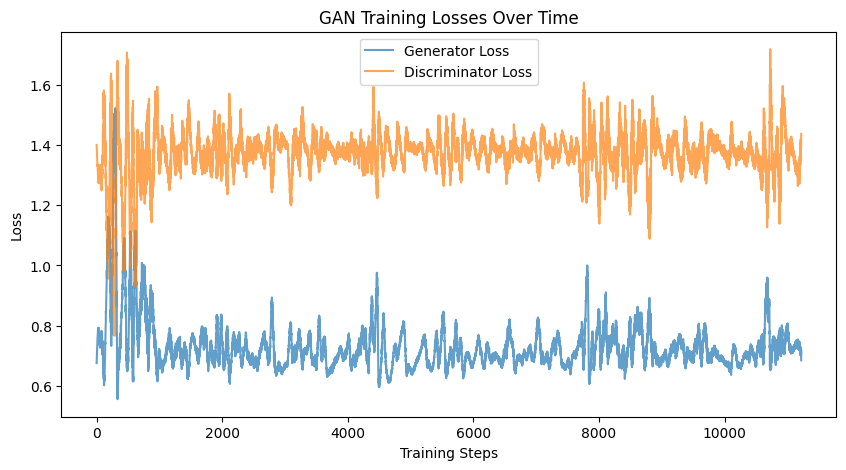


=== Generated Samples ===
Generated Samples (First 5):
[[3.87980789e-01 1.13335297e-01 6.83792651e-01 5.60679764e-04
  5.37569588e-03 4.97487485e-01 1.52892947e-01 6.96276315e-03
  5.20362119e-05 3.03887948e-03 3.44183296e-01 2.02663124e-01
  4.25193459e-01]
 [1.04107052e-01 1.30144125e-02 5.84642403e-02 1.55820628e-04
  1.00058355e-06 2.22847700e-01 5.70105910e-01 1.97865338e-05
  1.00000000e+00 2.37786189e-05 7.68769383e-01 2.30680257e-02
  3.13733041e-01]
 [3.99285197e-01 9.72685367e-02 9.64485526e-01 1.82289761e-04
  1.03801405e-02 5.82572460e-01 1.03557378e-01 9.76340938e-03
  8.57188598e-10 2.01851432e-03 1.02193579e-01 1.28807396e-01
  6.21417105e-01]
 [4.05667216e-01 1.35275558e-01 6.80951834e-01 2.85492628e-04
  5.95312612e-03 4.79301929e-01 1.52046308e-01 7.96422549e-03
  8.86960152e-07 2.18120706e-03 3.39445263e-01 1.98251992e-01
  4.85867441e-01]
 [3.76994193e-01 1.65416777e-01 4.58837271e-01 4.49357787e-03
  3.19358637e-03 4.47188497e-01 1.30817905e-01 1.09459404e-02
  2.

In [ ]:
# לאחר סיום האימון
# הדפסת מידע על תהליך האימון
print("=== Training Summary ===")
print(f"Number of epochs: {epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {lr}")
print(f"Loss function: Binary Cross-Entropy Loss (BCE)")
print(f"Optimizer: Adam (beta1=0.9, beta2=0.999)")

# הצגת גרף הפסדים
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss", alpha=0.7)
plt.plot(disc_losses, label="Discriminator Loss", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("GAN Training Losses Over Time")
plt.legend()
plt.show()

# דוגמאות של נתונים מזויפים
print("\n=== Generated Samples ===")
with torch.no_grad():
    fixed_noise = torch.randn((5, latent_dim)).to(device)
    generated_samples = generator(fixed_noise).cpu().numpy()
    print("Generated Samples (First 5):")
    print(generated_samples)


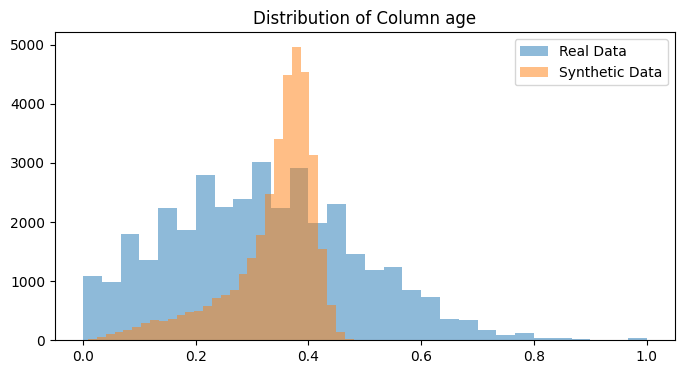

In [ ]:
import matplotlib.pyplot as plt

noise = torch.randn((len(X_train), latent_dim)).to(device)
synthetic_data = generator(noise).detach().cpu().numpy()

column_index = 0
plt.figure(figsize=(8, 4))
plt.hist(X_train.iloc[:, column_index], bins=30, alpha=0.5, label="Real Data")
plt.hist(synthetic_data[:, column_index], bins=30, alpha=0.5, label="Synthetic Data")
plt.legend()
plt.title(f"Distribution of Column {X_train.columns[column_index]}")
plt.show()


In [ ]:
# אימון על נתונים אמיתיים
clf_real = RandomForestClassifier()
clf_real.fit(X_train, y_train)
real_auc = roc_auc_score(y_test, clf_real.predict_proba(X_test)[:, 1])

# אימון על נתונים סינתטיים
synthetic_labels = y_train.sample(len(synthetic_data), replace=True).values
clf_synthetic = RandomForestClassifier()
clf_synthetic.fit(synthetic_data, synthetic_labels)
synthetic_auc = roc_auc_score(y_test, clf_synthetic.predict_proba(X_test)[:, 1])

print(f"Real Data AUC: {real_auc:.4f}")
print(f"Synthetic Data AUC: {synthetic_auc:.4f}")
print(f"Efficacy Score (Synthetic AUC / Real AUC): {synthetic_auc / real_auc:.4f}")


Real Data AUC: 0.9098
Synthetic Data AUC: 0.3145
Efficacy Score (Synthetic AUC / Real AUC): 0.3457


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#Detection Metric

In [ ]:
# נירמול מחדש
all_data = np.vstack([X_train.values, synthetic_data])
min_vals = all_data.min(axis=0)
max_vals = all_data.max(axis=0)

X_train_normalized = (X_train.values - min_vals) / (max_vals - min_vals)
synthetic_data_normalized = (synthetic_data - min_vals) / (max_vals - min_vals)


#Efficacy Metric


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np # Import
labels = [1] * len(X_train_normalized) + [0] * len(synthetic_data_normalized)
combined_data = np.vstack([X_train_normalized, synthetic_data_normalized])
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(
    combined_data, labels, test_size=0.2, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train_det, y_train_det)
y_pred_det = clf.predict_proba(X_test_det)[:, 1]

auc_score = roc_auc_score(y_test_det, y_pred_det)
print(f"Detection AUC: {auc_score:.4f}")

Detection AUC: 1.0000


#______________stop gan____________________

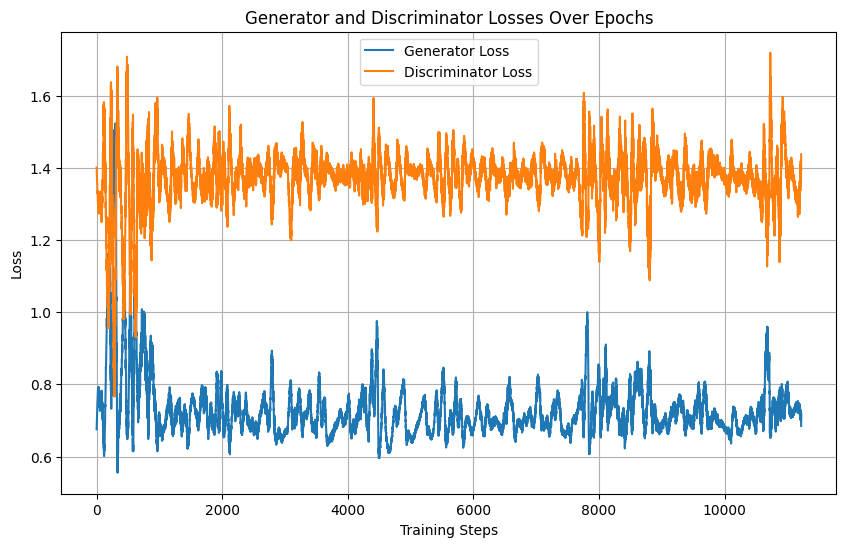

In [ ]:
# Plot Generator and Discriminator Losses
plt.figure(figsize=(10, 6))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.title('Generator and Discriminator Losses Over Epochs')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
synthetic_data_cgan = []
synthetic_labels_cgan = []

for _ in range(len(X_train) // batch_size):
    noise = torch.randn(batch_size, latent_dim).to(device)
    labels = torch.randint(0, num_labels, (batch_size,)).to(device)
    labels_onehot = F.one_hot(labels, num_classes=num_labels).float()
    generated_data = generator(noise, labels_onehot).detach().cpu().numpy()
    synthetic_data_cgan.append(generated_data)
    synthetic_labels_cgan.append(labels.cpu().numpy())

synthetic_data_cgan = np.vstack(synthetic_data_cgan)
synthetic_labels_cgan = np.hstack(synthetic_labels_cgan)


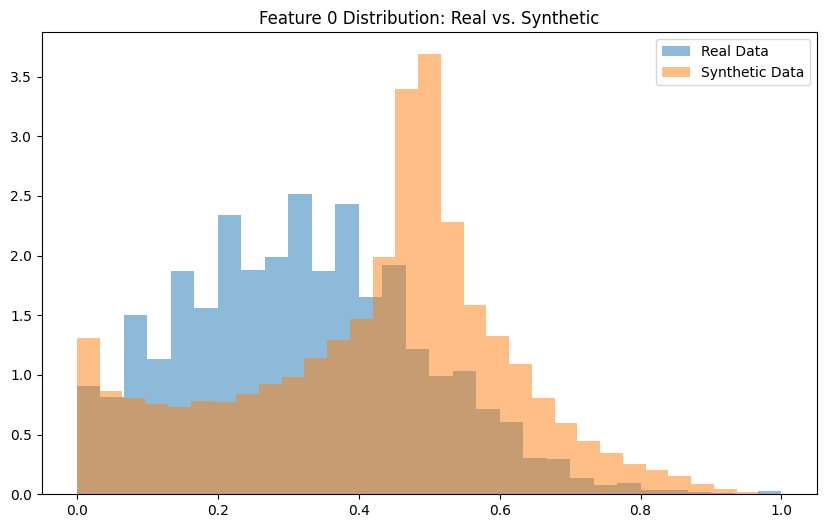

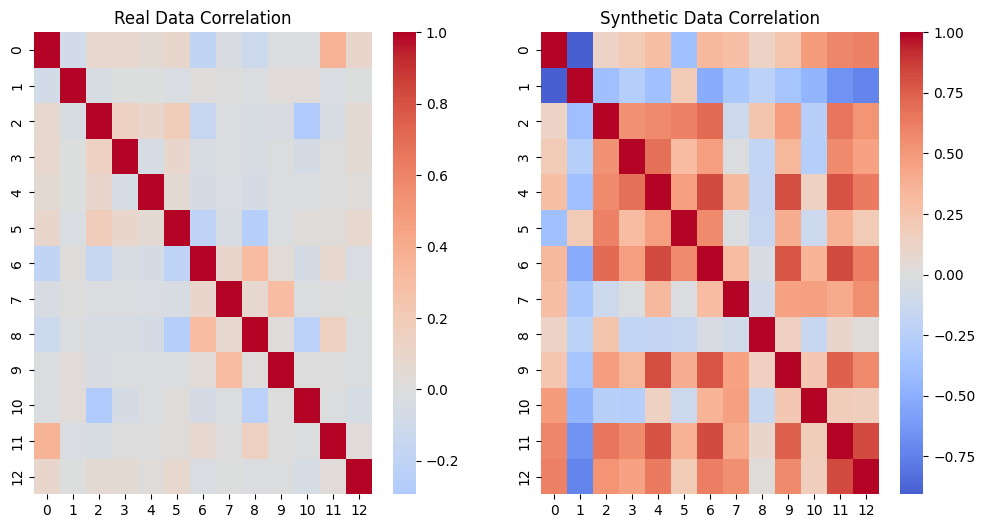

In [ ]:
import seaborn as sns

# Compare feature 0
plt.figure(figsize=(10, 6))
plt.hist(X_train.iloc[:, 0], bins=30, alpha=0.5, label='Real Data', density=True)
plt.hist(synthetic_data_cgan[:, 0], bins=30, alpha=0.5, label='Synthetic Data', density=True)
plt.title('Feature 0 Distribution: Real vs. Synthetic')
plt.legend()
plt.show()


# Correlation for real data
real_corr = np.corrcoef(X_train.values, rowvar=False)
synthetic_corr = np.corrcoef(synthetic_data_cgan, rowvar=False)

# Plot correlations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(real_corr, cmap='coolwarm', center=0)
plt.title('Real Data Correlation')
plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, cmap='coolwarm', center=0)
plt.title('Synthetic Data Correlation')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

# Combine real and synthetic data
combined_data = np.vstack([X_train.values, synthetic_data_cgan])  # Synthetic data from your generator
combined_labels = np.hstack([np.ones(len(X_train)), np.zeros(len(synthetic_data_cgan))])  # 1 for real, 0 for synthetic

# K-Fold Cross Validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)
aucs = []

for train_idx, test_idx in kf.split(combined_data):
    # Train-test split for this fold
    X_train_fold, X_test_fold = combined_data[train_idx], combined_data[test_idx]
    y_train_fold, y_test_fold = combined_labels[train_idx], combined_labels[test_idx]

    # Train Random Forest
    clf = RandomForestClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    y_pred = clf.predict_proba(X_test_fold)[:, 1]  # Probabilities for the positive class (real data)

    # Compute AUC
    auc = roc_auc_score(y_test_fold, y_pred)
    aucs.append(auc)

# Average AUC
avg_auc = np.mean(aucs)
print(f'Average AUC (Detection Metric): {avg_auc:.4f}')


Average AUC (Detection Metric): 1.0000


In [ ]:
# Train on real data
clf_real = RandomForestClassifier(random_state=42)
clf_real.fit(X_train, y_train)
auc_real = roc_auc_score(y_test, clf_real.predict_proba(X_test)[:, 1])

# Train on synthetic data
clf_synthetic = RandomForestClassifier(random_state=42)
clf_synthetic.fit(synthetic_data_cgan, synthetic_labels_cgan)
auc_synthetic = roc_auc_score(y_test, clf_synthetic.predict_proba(X_test)[:, 1])

# Efficacy ratio
efficacy_ratio = auc_synthetic / auc_real
print(f'Real AUC: {auc_real:.4f}, Synthetic AUC: {auc_synthetic:.4f}, Efficacy Ratio: {efficacy_ratio:.4f}')


Real AUC: 0.9037, Synthetic AUC: 0.7404, Efficacy Ratio: 0.8193


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


#בשביל הדוח

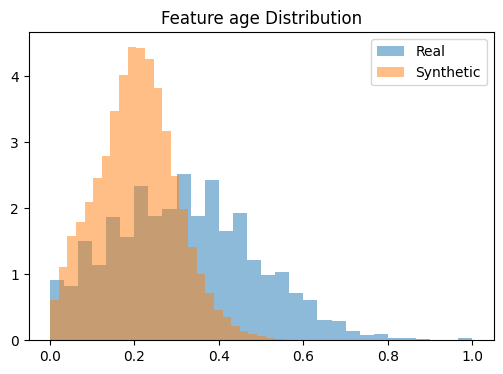

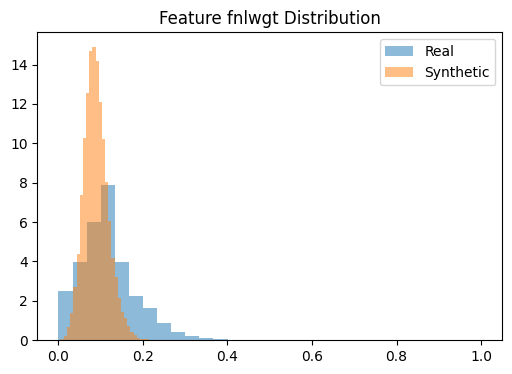

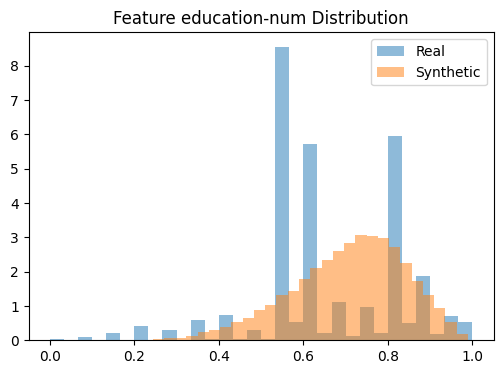

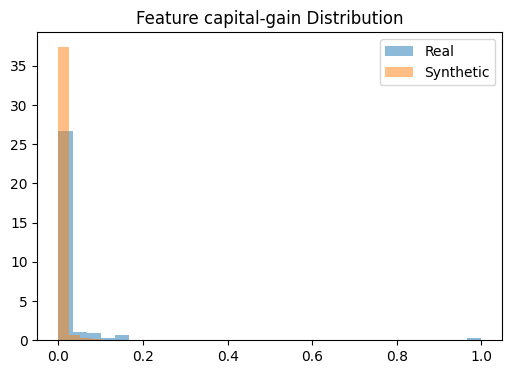

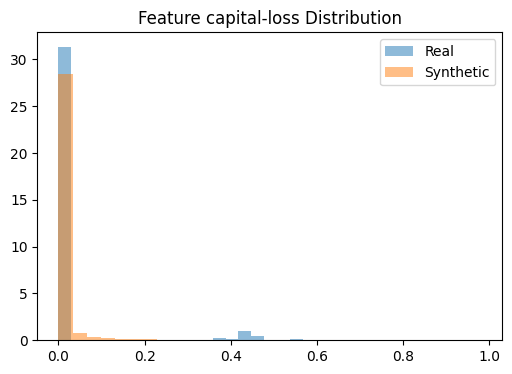

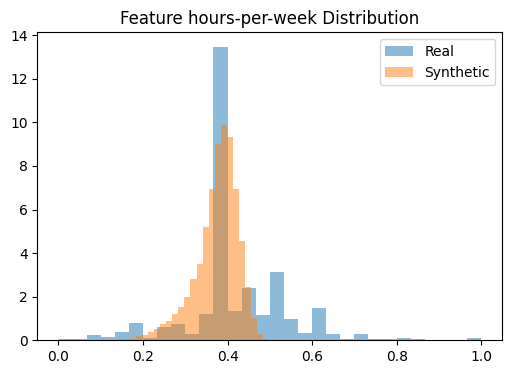

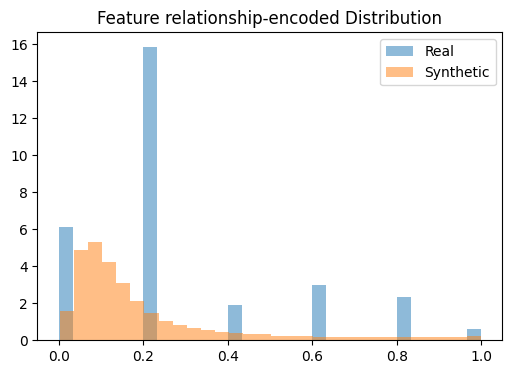

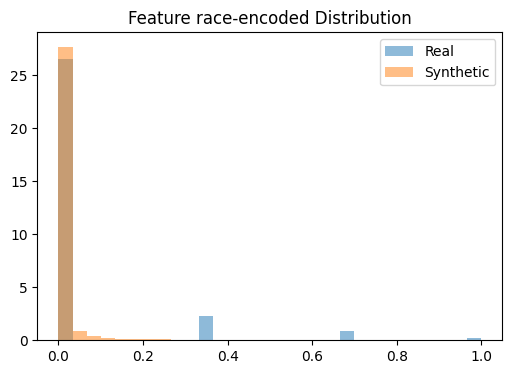

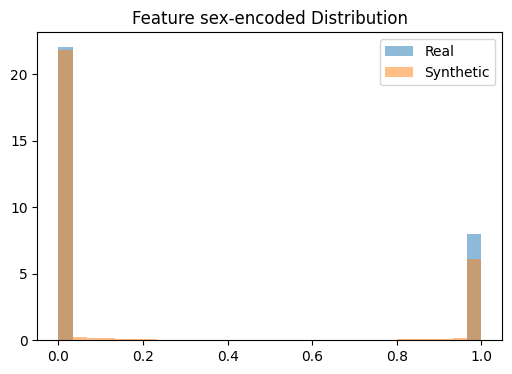

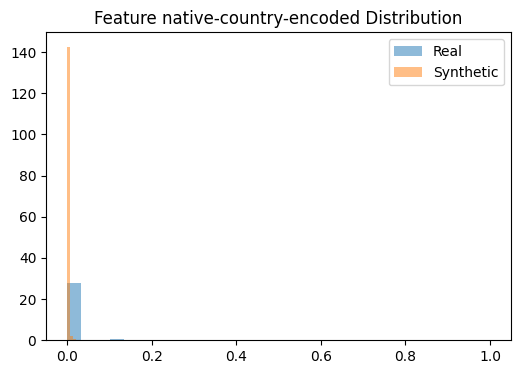

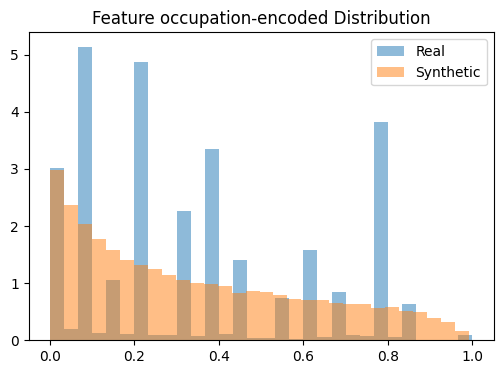

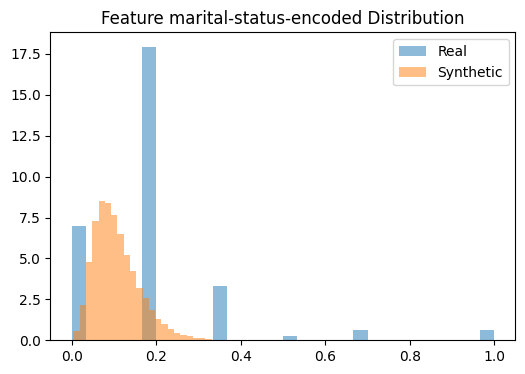

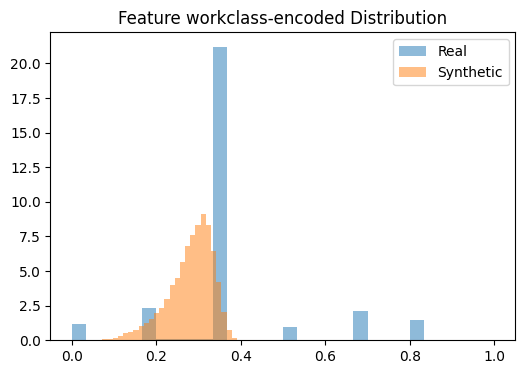

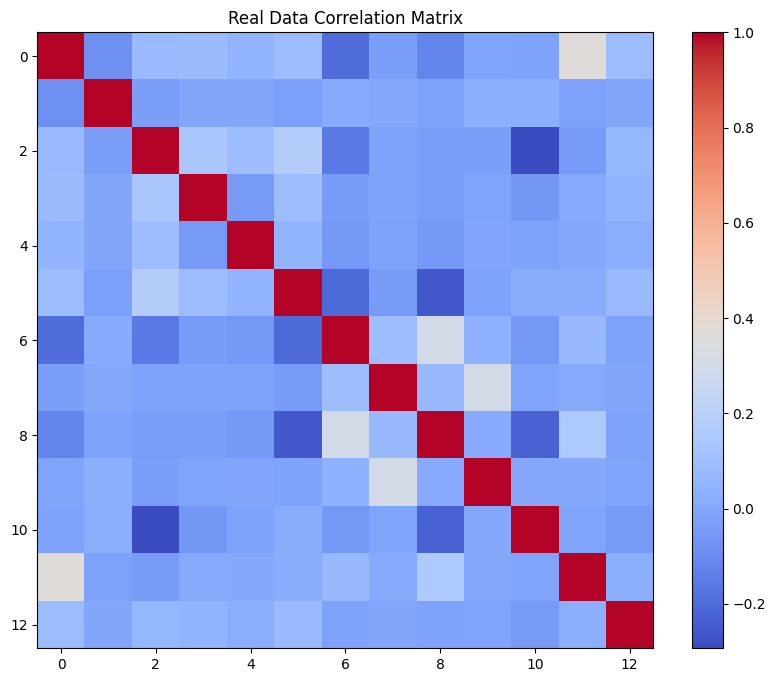

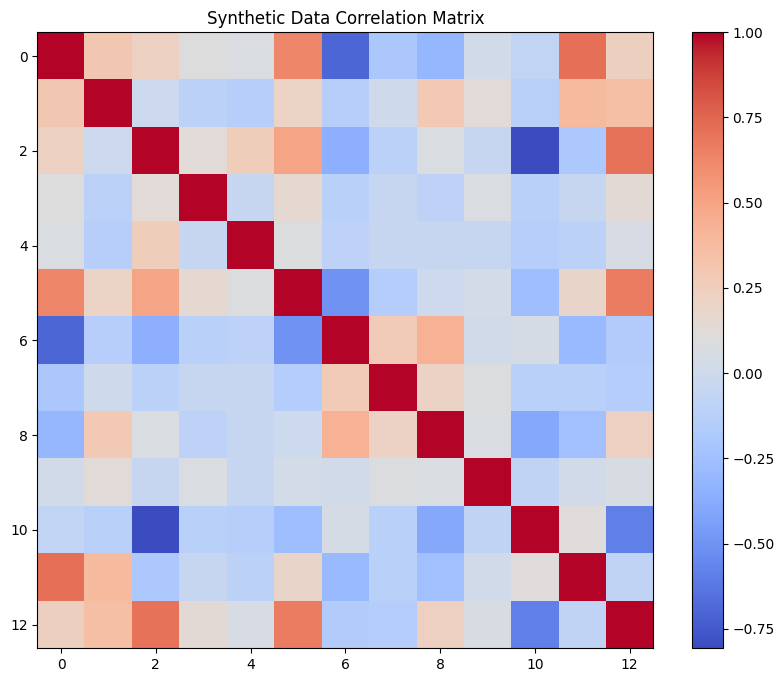

Detection Metric (Average AUC): 1.0


ValueError: Found input variables with inconsistent numbers of samples: [35910, 23944]

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# --- 6.b: יצירת נתונים סינתטיים ---
def generate_synthetic_data(generator, size, latent_dim, device):
    generator.eval()
    noise = torch.randn((size, latent_dim)).to(device)
    synthetic_data = generator(noise).detach().cpu().numpy()
    return synthetic_data

# גודל סט האימון
synthetic_data = generate_synthetic_data(generator, X_train.shape[0], latent_dim=100, device=device)

# --- 6.c: השוואת נתונים אמיתיים וסינתטיים ---
def compare_distributions(real_data, synthetic_data, column_names):
    # Create histograms for each feature
    for i, column in enumerate(column_names):
        plt.figure(figsize=(6, 4))
        plt.hist(real_data[:, i], bins=30, alpha=0.5, label="Real", density=True)
        plt.hist(synthetic_data[:, i], bins=30, alpha=0.5, label="Synthetic", density=True)
        plt.title(f"Feature {column} Distribution")
        plt.legend()
        plt.show()

    # Correlation matrices
    real_corr = np.corrcoef(real_data, rowvar=False)
    synthetic_corr = np.corrcoef(synthetic_data, rowvar=False)

    plt.figure(figsize=(10, 8))
    plt.title("Real Data Correlation Matrix")
    plt.imshow(real_corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.title("Synthetic Data Correlation Matrix")
    plt.imshow(synthetic_corr, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.show()

# השוואת הפצות
compare_distributions(X_train.values, synthetic_data, column_names=X_train.columns)

# --- 6.d: מדד Detection ---
def detection_metric(X_train, synthetic_data, y_train):
    # Combine real and synthetic data
    combined_X = np.vstack([X_train, synthetic_data])
    combined_y = np.array([1] * len(X_train) + [0] * len(synthetic_data))

    # Perform stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=4)
    auc_scores = []

    for train_index, test_index in skf.split(combined_X, combined_y):
        X_train_fold, X_test_fold = combined_X[train_index], combined_X[test_index]
        y_train_fold, y_test_fold = combined_y[train_index], combined_y[test_index]

        # Train Random Forest
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train_fold, y_train_fold)

        # Evaluate on test fold
        y_pred = clf.predict_proba(X_test_fold)[:, 1]
        auc = roc_auc_score(y_test_fold, y_pred)
        auc_scores.append(auc)

    avg_auc = np.mean(auc_scores)
    print(f"Detection Metric (Average AUC): {avg_auc}")
    return avg_auc

# מדד detection
detection_metric(X_train.values, synthetic_data, y_train.values)

# --- 6.e: מדד Efficacy ---
def efficacy_metric(X_train, synthetic_data, y_train, y_test):
    # Train on real data
    clf_real = RandomForestClassifier(random_state=42)
    clf_real.fit(X_train, y_train)
    auc_real = roc_auc_score(y_test, clf_real.predict_proba(X_test)[:, 1])

    # Train on synthetic data
    clf_synthetic = RandomForestClassifier(random_state=42)
    clf_synthetic.fit(synthetic_data, y_train)  # שימוש בתוויות של הנתונים המקוריים
    auc_synthetic = roc_auc_score(y_test, clf_synthetic.predict_proba(X_test)[:, 1])

    # Efficacy ratio
    efficacy_ratio = auc_synthetic / auc_real
    print(f"Efficacy Metric: Real AUC: {auc_real}, Synthetic AUC: {auc_synthetic}, Ratio: {efficacy_ratio}")
    return efficacy_ratio

# מדד efficacy
efficacy_metric(X_train.values, synthetic_data, y_train.values, y_test.values)
